<a href="https://colab.research.google.com/github/ekingit/DeepForecast/blob/main/2_0_Periodic_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive

drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/Colab\ Notebooks/weather_forecast/Data/data.py /content/data.py
from data import Sine_Data, Weather_Data

Mounted at /content/gdrive


# Data

In [ ]:
nat_data = Weather_Data('/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Data/weather_prediction_dataset.csv','BASEL_temp_max')
synt_data = Sine_Data(2/365.25,3654,3/2)
X_sine = synt_data.x.unsqueeze(-1)
X_raw = nat_data.tens #all data
X_sine.shape, X_raw.shape

(torch.Size([3654, 1]), torch.Size([3654, 1]))

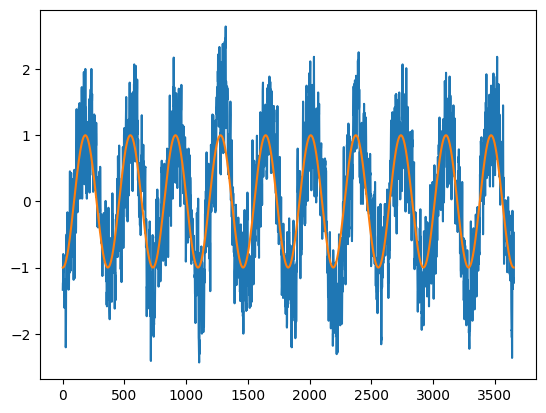

In [ ]:
plt.plot(X_raw)
plt.plot(X_sine)

# Global Model

In [ ]:
class RNN_model(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers=1, num_out=1):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens, num_layers)
        self.linear = nn.Linear(num_hiddens, num_out)
    def forward(self, X, H):
        state, H = self.rnn(X,H)
        pred = self.linear(state)
        return pred, H

In [ ]:
def train_test_RNN(model, hidden_size, num_layers, X, Y, split_year, optimizer, criterion, device='cuda'):
    model.train()
    optimizer.zero_grad()
    X, Y = X.to(device), Y.to(device)
    model = model.to(device)
    H = torch.zeros(num_layers,hidden_size,device=device)
    days_of_years = [0]+[sum(366 if i % 4 == 0 else 365 for i in range(year+1)) for year in range(0,10)]
#train
    Y_hat, H = model(X[0:days_of_years[split_year]], H)
    train_loss = criterion(Y[0:days_of_years[split_year]],Y_hat)
    train_loss.backward()
    optimizer.step()
    train_loss = train_loss.item()
    model.eval()
#validation
    Y_hat, H = model(X[days_of_years[split_year]:days_of_years[split_year+1]],H)
    val_loss = criterion(Y[days_of_years[split_year]:days_of_years[split_year+1]],Y_hat).item()
#test
    Y_hat, H = model(X[days_of_years[split_year+1]:],H)
    test_loss = criterion(Y[days_of_years[split_year+1]:],Y_hat).item()
    return train_loss, val_loss, test_loss

In [ ]:
#Run!
split_year = 8
hidden_size = 10
num_layers = 3
num_epoch = 10000
lr = 1e-4
mse_loss = nn.MSELoss()
rnn_model = RNN_model(1,hidden_size,num_layers)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)
train_loss_list = []
val_loss_list = []
test_loss_list = []
for epoch in range(num_epoch):
    train_loss, val_loss, test_loss = train_test_RNN(rnn_model, hidden_size, num_layers, X_sine, X_raw, split_year, optimizer, mse_loss)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    test_loss_list.append(test_loss)
    if epoch % 1000 == 0:
        print(f"epoch: {epoch} train_loss: {train_loss} val_loss: {val_loss} test_loss: {test_loss}")

epoch: 0 train_loss: 0.9657257795333862 val_loss: 0.7952697277069092 test_loss: 1.0270646810531616
epoch: 1000 train_loss: 0.3069089353084564 val_loss: 0.25337153673171997 test_loss: 0.23858773708343506
epoch: 2000 train_loss: 0.2818708121776581 val_loss: 0.23650382459163666 test_loss: 0.21939395368099213
epoch: 3000 train_loss: 0.2784374952316284 val_loss: 0.23858478665351868 test_loss: 0.22060677409172058
epoch: 4000 train_loss: 0.27705875039100647 val_loss: 0.23640133440494537 test_loss: 0.21962657570838928
epoch: 5000 train_loss: 0.27580228447914124 val_loss: 0.2332029789686203 test_loss: 0.2195582091808319
epoch: 6000 train_loss: 0.2740694284439087 val_loss: 0.2303316593170166 test_loss: 0.22421476244926453
epoch: 7000 train_loss: 0.2715395987033844 val_loss: 0.23137180507183075 test_loss: 0.2315962016582489
epoch: 8000 train_loss: 0.2702687680721283 val_loss: 0.2358015924692154 test_loss: 0.22955092787742615
epoch: 9000 train_loss: 0.26989850401878357 val_loss: 0.2369295954704284

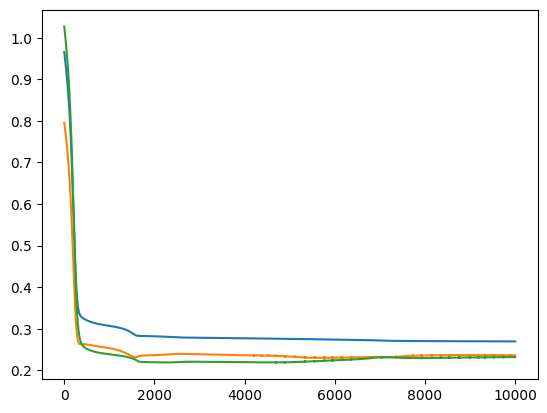

In [ ]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.plot(test_loss_list)